In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle
from matplotlib import style
import time
import random

style.use("ggplot")

In [2]:
class TrafficLights:
    def __init__(self, env):
        self.x1 = 33 // env.m
        self.y1 = 33 % env.n
        self.c1 = 'red'
        self.x2 = 36 // env.m
        self.y2 = 36 % env.n
        self.c2 = 'green'
        self.x3 = 63 // env.m
        self.y3 = 63 % env.n
        self.c3 = 'green'
        self.x4 = 66 // env.m
        self.y4 = 66 % env.n
        self.c4 = 'red'

    def __str__(self):
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def action(self, choice):
        if choice == 1:
            if self.c1 == 'green':
                self.c1 = 'red'
            else:
                self.c1 = 'green'
            if self.c2 == 'green':
                self.c2 = 'red'
            else:
                self.c2 = 'green'
            if self.c3 == 'green':
                self.c3 = 'red'
            else:
                self.c3 = 'green'
            if self.c4 == 'green':
                self.c4 = 'red'
            else:
                self.c4 = 'green'

In [3]:
class Car:
    def __init__(self, pos, flow, env):
        self.x = pos // env.m
        self.y = pos % env.n
        self.flow = flow
        self.same_pos = False
        
    def move(self, env):
        if self.flow == 'H-R':
            if self.y !=9:
                if self.x == 5 and self.y == 3:
                    if env.TrafficLights.c3 == 'green':
                        self.y += 1
                        self.same_pos = False
                    else:
                        self.same_pos = True
                else:
                    if self.check_next_cell(env):
                        self.same_pos = True
                    else:
                        self.y += 1
                        self.same_pos = False
        elif self.flow == 'H-L':
            if self.y !=0:
                if self.x == 4 and self.y == 6:
                    if env.TrafficLights.c2 == 'green':
                        self.y -= 1
                        self.same_pos = False
                    else:
                        self.same_pos = True
                else:
                    if self.check_next_cell(env):
                        self.same_pos = True
                    else:
                        self.y -= 1
                        self.same_pos = False
        elif self.flow == 'V-U':
            if self.x != 0:
                if self.x == 6 and self.y == 5:
                    if env.TrafficLights.c4 == 'green':
                        self.x -= 1
                        self.same_pos = False
                    else:
                        self.same_pos = True
                else:
                    if self.check_next_cell(env):
                        self.same_pos = True
                    else:
                        self.x -= 1
                        self.same_pos = False
        elif self.flow == 'V-D':
            if self.x != 9:
                if self.x == 3 and self.y == 4:
                    if env.TrafficLights.c1 == 'green':
                        self.x += 1
                        self.same_pos = False
                    else:
                        self.same_pos = True
                else:
                    if self.check_next_cell(env):
                        self.same_pos = True
                    else:
                        self.x += 1
                        self.same_pos = False
                    
    def check_next_cell(self, env):
        copy = env.Cars.copy()
        copy.remove(self)
        for car in copy:
            if self.flow == 'H-R' and car.flow == 'H-R':
                if self.y+1 == car.y:
                    return True
        for car in copy:
            if self.flow == 'H-L' and car.flow == 'H-L':
                if self.y-1 == car.y:
                    return True
        for car in copy:
            if self.flow == 'V-U' and car.flow == 'V-U':
                if self.x-1 == car.x:
                    return True
        for car in copy:
            if self.flow == 'V-D' and car.flow == 'V-D':
                if self.x+1 == car.x:
                    return True
        return False

In [4]:
class GridWorld(object):
    def __init__(self, m, n):
        self.grid = np.zeros((m,n,3), dtype = np.uint8)
        self.m = m
        self.n = n
        self.colors = {'red': (0, 0, 255),
                       'blue': (255, 0, 0),
                       'green': (0, 255, 0),
                       'yellow': (0, 255, 255),
                       'grey': (105, 105, 105)
                      }
        self.finish_pos = [5, 40, 59, 94]
        self.cars_counter = 0
        self.Buildings = [0, 1, 2, 3, 6, 7, 8, 9,
                          10, 11, 12, 13, 16, 17, 18, 19,
                          20, 21, 22, 23, 26, 27, 28, 29,
                          30, 31, 32, 33, 36, 37, 38, 39,
                          60, 61, 62, 63, 66, 67, 68, 69,
                          70, 71, 72, 73, 76, 77, 78, 79,
                          80, 81, 82, 83, 86, 87, 88, 89,
                          90, 91, 92, 93, 96, 97, 98, 99]
        self.addBuildings(self)
        self.addTrafficLights(self)
        self.addCars(self)

    def addBuildings(self, env):
        for building in env.Buildings:
            x = building // env.m
            y = building % env.n
            env.grid[x][y] = env.colors['grey']
    
    def addTrafficLights(self, env):
        self.TrafficLights = TrafficLights(env)
        env.grid[env.TrafficLights.x1][env.TrafficLights.y1] = env.colors[env.TrafficLights.c1]
        env.grid[env.TrafficLights.x2][env.TrafficLights.y2] = env.colors[env.TrafficLights.c2]
        env.grid[env.TrafficLights.x3][env.TrafficLights.y3] = env.colors[env.TrafficLights.c3]
        env.grid[env.TrafficLights.x4][env.TrafficLights.y4] = env.colors[env.TrafficLights.c4]
    
    def addCars(self, env):
        car1 = Car(random.choice([4, 14, 24, 34]), 'V-D', env)
        car2 = Car(random.choice([65, 75, 85, 95]), 'V-U', env)
        car3 = Car(random.choice([50, 51, 52, 53]), 'H-R', env)
        car4 = Car(random.choice([46, 47, 48, 49]), 'H-L', env)
        cars = []
        cars.append(car1)
        cars.append(car2)
        cars.append(car3)
        cars.append(car4)
        self.Cars = cars
        for car in self.Cars:
            self.grid[car.x][car.y] = self.colors['yellow']
    
    def getState(self):
        lane1 = []
        lane2 = []
        lane3 = []
        lane4 = []
        
        for i in range(5):
            if self.grid[5][i][0] == 0 and self.grid[5][i][1] == 255 and self.grid[5][i][2] == 255:
                lane1.append(1)
            else:
                lane1.append(0)
        car_in_54 = False
        for car in list(filter(lambda x: x.flow == 'H-R', env.Cars)):
            if car.x == 5 and car.y == 4:
                car_in_54 = True
                break
        if car_in_54:
            lane1.append(1)
        else:
            lane1.append(0)
        lane1_state = str(lane1[0]) + str(lane1[1]) + str(lane1[2]) + str(lane1[3]) + str(lane1[4])
        
        car_in_55 = False
        for car in list(filter(lambda x: x.flow == 'V-U', env.Cars)):
            if car.x == 5 and car.y == 5:
                car_in_55 = True
                break
        if car_in_55:
            lane2.append(1)
        else:
            lane2.append(0)
        for j in range(6, 10):
            if self.grid[j][5][0] == 0 and self.grid[j][5][1] == 255 and self.grid[j][5][2] == 255:
                lane2.append(1)
            else:
                lane2.append(0)
        lane2_state = str(lane2[0]) + str(lane2[1]) + str(lane2[2]) + str(lane2[3]) + str(lane2[4])
        
        car_in_45 = False
        for car in list(filter(lambda x: x.flow == 'H-L', env.Cars)):
            if car.x == 4 and car.y == 5:
                car_in_45 = True
                break
        if car_in_45:
            lane3.append(1)
        else:
            lane3.append(0)
        for k in range(6, 10):
            if self.grid[4][k][0] == 0 and self.grid[4][k][1] == 255 and self.grid[4][k][2] == 255:
                lane3.append(1)
            else:
                lane3.append(0)
        lane3_state = str(lane3[0]) + str(lane3[1]) + str(lane3[2]) + str(lane3[3]) + str(lane3[4])
        
        
        for l in range(4):
            if self.grid[l][4][0] == 0 and self.grid[l][4][1] == 255 and self.grid[l][4][2] == 255:
                lane4.append(1)
            else:
                lane4.append(0)
        car_in_44 = False
        for car in list(filter(lambda x: x.flow == 'V-D', env.Cars)):
            if car.x == 4 and car.y == 4:
                car_in_44 = True
                break
        if car_in_44:
            lane4.append(1)
        else:
            lane4.append(0)
        lane4_state = str(lane4[0]) + str(lane4[1]) + str(lane4[2]) + str(lane4[3]) + str(lane4[4])

        if self.TrafficLights.c1 == 'green':
            flow = 'V'
        else:
            flow = 'H'
            
        return lane1_state, lane2_state, lane3_state, lane4_state, flow
        
    def update_grid(self):
        self.grid = np.zeros((self.m, self.n, 3), dtype = np.uint8)
        self.addBuildings(self)
        self.grid[self.TrafficLights.x1][self.TrafficLights.y1] = self.colors[self.TrafficLights.c1]
        self.grid[self.TrafficLights.x2][self.TrafficLights.y2] = self.colors[self.TrafficLights.c2]
        self.grid[self.TrafficLights.x3][self.TrafficLights.y3] = self.colors[self.TrafficLights.c3]
        self.grid[self.TrafficLights.x4][self.TrafficLights.y4] = self.colors[self.TrafficLights.c4]
        for car in self.Cars:
            self.grid[car.x][car.y] = self.colors['yellow']
        return self.grid
            
    def render(self):
        self.grid = self.update_grid()
        img = Image.fromarray(self.grid, 'RGB')
        img = img.resize((300, 300))
        cv2.imshow("image", np.array(img))
        

In [5]:
start_q_table = 'qtable-1608053442.pickle'
if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    l = ['{0:05b}'.format(i) for i in range(32)]
    for value in l:
        for val in l:
            for va in l:
                for v in l:
                    for s in ['H', 'V']:
                        q_table[(value, val, va, v, s)] = [np.random.(-100, -10) for i in range(2)]

else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

In [ ]:
n_episodes = 100000
show_every = 10000

congested_penalty = 2
crash_penalty = 300
finish_reward = 10
epsilon = 0.9
eps_decay = 0.9998
learning_rate = 0.1
discount = 0.95

episode_rewards = []
episodes_finish_cars = []
episodes_crashes = []

for episode in range(n_episodes):
    env = GridWorld(10, 10)
    if episode % show_every == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{show_every} ep mean: {np.mean(episode_rewards[-show_every:])}")
        show = True
    else:
        show = False
    episode_reward = 0
    episode_finish_cars = 0
    i = 0
    if show and i == 0:
        grid_to_show = env.grid
        for j in range(env.m):
                for k in range(env.n):
                    grid_to_show[j][k] = grid_to_show[j][k][::-1]
        img = Image.fromarray(grid_to_show, 'RGB')
        img = img.resize((300, 300), resample = Image.NEAREST)
        img.save('images/trained_IA/episode'+str(episode)+'/'+str(i)+'.jpeg')
        
    while i<100:
        i += 1
        cars_counter = 0
        congested_cars = 0
        obs = env.getState()
        if np.random.random() > epsilon:
            choice = np.argmax(q_table[obs])
        else:
            choice = np.random.randint(0, 2)
        env.TrafficLights.action(choice)   
        for car in env.Cars:
            car_pos = car.x*10 + car.y
            if car_pos in env.finish_pos:
                env.Cars.remove(car)
                cars_counter += 1
            else:
                car.move(env)
                if car.same_pos:
                    congested_cars += 1
        for car in env.Cars:
            copy = env.Cars.copy()
            copy.remove(car)
            crash = False
            for c in copy:
                if car.x == c.x and car.y == c.y:
                    crash = True
                    break
            if crash:
                break
        if crash:
            reward = -crash_penalty
        else:
            if choice == 1:
                #finish_reward*cars_counter
                reward = -congested_penalty*congested_cars - 1
            else:
                reward = -congested_penalty*congested_cars
            
        env.grid = env.update_grid()
        new_obs = env.getState()
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][choice]
        new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)
        q_table[obs][choice] = new_q
        
        if i%2 == 0:
            av_pos = [4, 49, 50, 95]
            for p in av_pos:
                x_pos = p // env.m
                y_pos = p % env.n
            if env.grid[x_pos][y_pos][0] == 0 and env.grid[x_pos][y_pos][1] == 255 and env.grid[x_pos][y_pos][2] == 255:
                av_pos.remove(p)
            sel_pos = random.choice(av_pos)
            if sel_pos == 4:
                flow = 'V-D'
            elif sel_pos == 49:
                flow = 'H-L'
            elif sel_pos == 50:
                flow = 'H-R'
            else:
                flow = 'V-U'
            car = Car(sel_pos, flow, env)
            env.Cars.append(car)
            
        if show:
            grid_to_show = env.update_grid()
            for j in range(env.m):
                for k in range(env.n):
                    grid_to_show[j][k] = grid_to_show[j][k][::-1]
            img = Image.fromarray(grid_to_show, 'RGB')
            img = img.resize((300, 300), resample = Image.NEAREST)
            img.save('images/trained_IA/episode'+str(episode)+'/'+str(i)+'.jpeg')
            cv2.imshow("image", np.array(img))
            if reward == -crash_penalty:
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
        episode_reward = episode_reward + reward + finish_reward*cars_counter
        episode_finish_cars += cars_counter
        if reward == -crash_penalty:
            break
    episode_rewards.append(episode_reward)
    episodes_finish_cars.append(episode_finish_cars)
    episodes_crashes.append(crash)
    epsilon *= eps_decay

moving_avg = np.convolve(episode_rewards, np.ones((show_every,))/show_every, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {show_every}ma")
plt.xlabel("episode #")
plt.show()

on #0, epsilon is 0.9
10000 ep mean: nan


C:\Users\user\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\user\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on #10000, epsilon is 0.12177739374998418
10000 ep mean: -240.2661
on #20000, epsilon is 0.01647748180948748
10000 ep mean: -122.6299
on #30000, epsilon is 0.0022295386559135037
10000 ep mean: -100.1168


---

In [10]:
for i in range(0,100000, 1000):
    print(sum(episodes_finish_cars[i:i+1000]))

3373
4649
5303
7894
9320
10917
12707
15503
16802
18738
19932
23251
24240
24887
25576
28686
29130
29841
30971
33401
32493
32525
31647
31256
32571
31601
34557
34827
33944
35164
32687
31150
32092
33436
34790
33327
34434
32586
32834
34681
34163
34181
34766
36076
35633
35667
35055
36749
35541
34158
34980
36209
35737
35717
36295
34850
36262
36345
35738
35794
35450
35660
35851
36564
34915
35105
35088
35871
35708
35972
34587
34892
35149
35226
35597
35548
36150
35787
36430
34903
34992
35438
35708
34865
34850
36465
35314
35647
35152
34639
35640
35793
34821
34963
35247
34800
35180
34998
35268
35524


In [11]:
with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

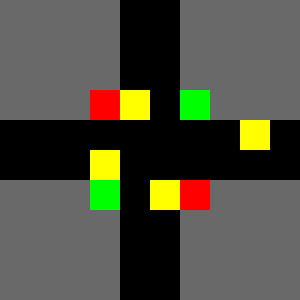

In [14]:
env = GridWorld(10, 10)
grid_to_show = env.update_grid()
for i in range(env.m):
    for j in range(env.n):
        grid_to_show[i][j] = grid_to_show[i][j][::-1]
img = Image.fromarray(grid_to_show, 'RGB')
img = img.resize((300, 300), resample = Image.NEAREST)
img

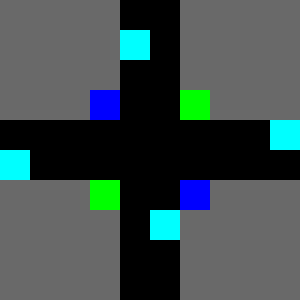

In [31]:
env = GridWorld(10, 10)
env.grid = env.update_grid()
img = Image.fromarray(env.grid, 'RGB')
img = img.resize((300, 300), resample = Image.NEAREST)
img

In [39]:
env.grid[1][4] = env.grid[1][4][::-1]

In [40]:
env.grid[1][4]

array([255, 255,   0], dtype=uint8)